# Thử nghiệm tham số cho Self-Training

**Mục tiêu:**
Notebook này thực hiện quá trình sweep (thử nghiệm) các tham số quan trọng của thuật toán Self-Training để tìm ra cấu hình tối ưu. Cụ thể:
1.  Sử dụng `papermill` để chạy notebook `04_semi_self_training.ipynb` với nhiều bộ tham số khác nhau.
    -   `TAU` (Ngưỡng tự tin): `[0.9, 0.8, 0.7, 0.6]`
    -   `MAX_ITER` (Số vòng lặp tối đa): `[10, 20, 30, 40]`
2.  Tự động lưu 8 bộ kết quả (metrics, predictions, alerts) vào thư mục `data/processed/` với tiền tố `10_ID_*`.
3.  Tổng hợp các file metrics đã tạo ra.
4.  Trực quan hóa kết quả để so sánh hiệu năng giữa các cấu hình và tìm ra bộ tham số tốt nhất.

In [6]:
from pathlib import Path
import papermill as pm

# -------- Cấu hình thử nghiệm --------
# Thư mục gốc của dự án
PROJECT_ROOT = Path(".").resolve().parent
print(f"Project Root: {PROJECT_ROOT}")

# Tên kernel Jupyter
KERNEL = "KhaiPhaDuLieu"

# Danh sách các tham số cần thử nghiệm
# Bạn có thể thay đổi các giá trị này để thử nghiệm
TAU_LIST = [0.9, 0.8, 0.7, 0.6] 
MAX_ITER_LIST = [10, 20, 30, 40]

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard


In [ ]:
# -------- Chạy thử nghiệm với Papermill --------
experiment_id = 1
total_experiments = len(TAU_LIST) * len(MAX_ITER_LIST)

for tau in TAU_LIST:
    for max_iter in MAX_ITER_LIST:
        print(f"--- Thử nghiệm {experiment_id}/{total_experiments}: TAU={tau}, MAX_ITER={max_iter} ---")

        # Định nghĩa đường dẫn cho file output
        # Đường dẫn output_path tương đối với thư mục hiện tại (notebooks)
        metrics_path = f"data/processed/10_{experiment_id:02d}_metrics_self_training.json"
        pred_sample_path = f"data/processed/10_{experiment_id:02d}_predictions_self_training_sample.csv"
        alerts_sample_path = f"data/processed/10_{experiment_id:02d}_alerts_self_training_sample.csv"
        output_notebook_path = f"runs/10_{experiment_id:02d}_self_training_run.ipynb"

        try:
            pm.execute_notebook(
                # Vì cả 2 notebooks đều nằm trong cùng thư mục `notebooks`,
                # chúng ta chỉ cần gọi tên file.
                input_path="04_semi_self_training.ipynb",
                output_path=output_notebook_path,
                parameters=dict(
                    SEMI_DATASET_PATH="data/processed/02_dataset_for_semi.parquet",
                    CUTOFF="2017-01-01",
                    TAU=tau,
                    MAX_ITER=max_iter,
                    MIN_NEW_PER_ITER=20,
                    VAL_FRAC=0.10,
                    RANDOM_STATE=42,
                    METRICS_PATH=metrics_path,
                    PRED_SAMPLE_PATH=pred_sample_path,
                    ALERTS_SAMPLE_PATH=alerts_sample_path,
                    ALERT_FROM_CLASS="Unhealthy",
                ),
                kernel_name=KERNEL,
                # Chạy từ thư mục gốc của dự án để các đường dẫn `data/...` được giải quyết đúng
                cwd=str(PROJECT_ROOT)
            )
            print(f"✅ Hoàn thành và lưu kết quả tại: {metrics_path}")
        except Exception as e:
            print(f"❌ Lỗi khi chạy thử nghiệm {experiment_id}: {e}")
        
        experiment_id += 1

print("\n🎉 Tất cả thử nghiệm đã hoàn tất!")

# Tổng hợp và phân tích kết quả

Sau khi chạy tất cả các thử nghiệm, chúng ta sẽ đọc các file metrics `.json` đã được tạo ra và tổng hợp chúng vào một DataFrame duy nhất để dễ dàng phân tích và trực quan hóa.

In [5]:
import json
import pandas as pd
from pathlib import Path
from IPython.display import display
import glob

# -------- Cấu hình --------
PROJECT_ROOT = Path(".").resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "processed"

# -------- Đọc và tổng hợp kết quả (Tự động) --------
# Tự động tìm tất cả các file metrics của thử nghiệm 10
metric_files = glob.glob(str(DATA_DIR / "10_*_metrics_self_training.json"))

results = []
for file_path in metric_files:
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        
        # Trích xuất thông tin cần thiết
        config = data.get("st_cfg", {})
        test_metrics = data.get("test_metrics", {})
        
        # Lấy ID thử nghiệm từ tên file
        experiment_id = Path(file_path).stem.split('_')[1]
        
        results.append({
            "experiment_id": int(experiment_id),
            "tau": config.get("tau"),
            "max_iter": config.get("max_iter"),
            "f1_macro": test_metrics.get("f1_macro"),
            "accuracy": test_metrics.get("accuracy"),
            "precision_macro": test_metrics.get("precision_macro"),
            "recall_macro": test_metrics.get("recall_macro"),
        })

# Tạo DataFrame
if results:
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by=["tau", "max_iter"], ascending=[False, True]).reset_index(drop=True)
    
    print("Bảng tổng hợp kết quả thử nghiệm:")
    display(df_results)
else:
    print("Không có kết quả nào để hiển thị. Vui lòng chạy cell thử nghiệm trước.")


Bảng tổng hợp kết quả thử nghiệm:


,experiment_id,tau,max_iter,f1_macro,accuracy,precision_macro,recall_macro
0,1,0.9,2,0.512856,0.602963,None,None
1,2,0.9,3,0.525201,0.598404,None,None
2,3,0.8,2,0.527013,0.600504,None,None
3,4,0.8,3,0.521504,0.594206,None,None


# Trực quan hóa kết quả

Bây giờ, chúng ta sẽ sử dụng DataFrame tổng hợp để tạo các biểu đồ so sánh, giúp xác định cấu hình tham số nào mang lại hiệu quả tốt nhất.

1.  **Biểu đồ cột nhóm:** So sánh trực tiếp F1-macro giữa các giá trị TAU.
2.  **Biểu đồ nhiệt (Heatmap):** Cung cấp cái nhìn tổng quan về hiệu suất trên toàn bộ không gian tham số.

Biểu đồ cột đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\10_01_f1_macro_comparison.png


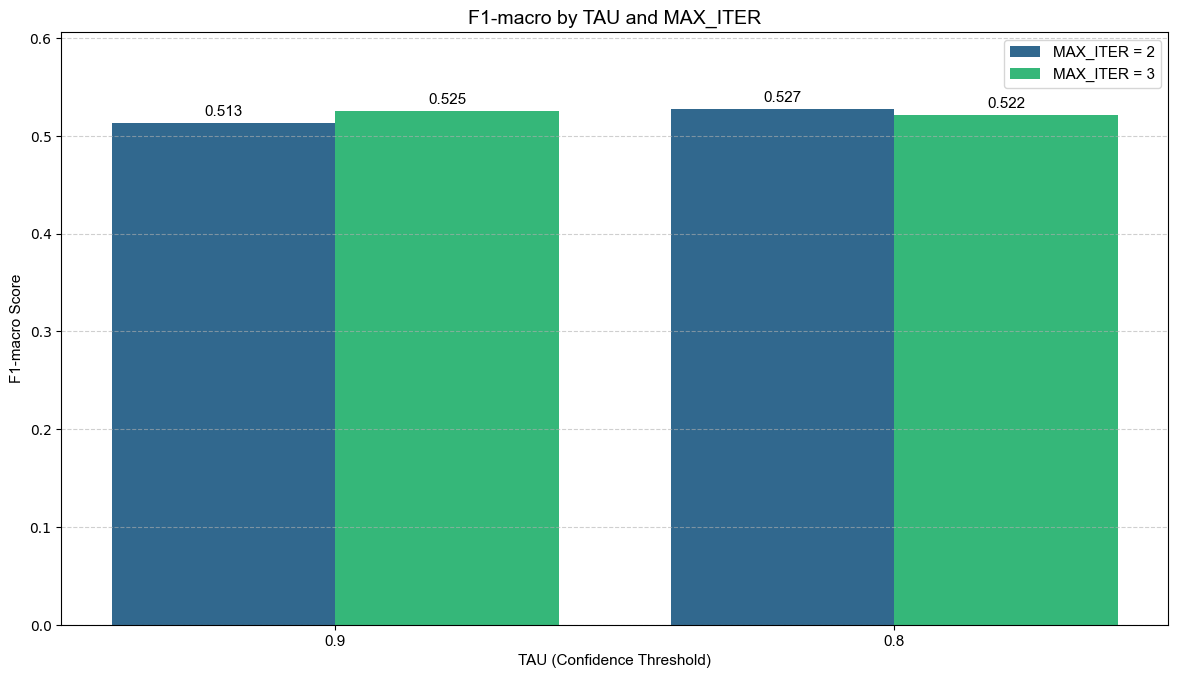

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# -------- Cấu hình biểu đồ --------
IMAGES_DIR = PROJECT_ROOT / "images"
IMAGES_DIR.mkdir(exist_ok=True)
FONT_CONFIG = {'fontname': 'Arial', 'fontsize': 11}
# Tự động tạo bảng màu
color_palette = sns.color_palette("viridis", n_colors=df_results["max_iter"].nunique())
COLORS = {iter_val: color for iter_val, color in zip(sorted(df_results["max_iter"].unique()), color_palette)}


# -------- Biểu đồ 1: So sánh F1-macro (Biểu đồ cột nhóm - Tự động) --------
if 'df_results' in locals() and not df_results.empty:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Chuẩn bị dữ liệu
    taus = sorted(df_results["tau"].unique(), reverse=True)
    max_iters = sorted(df_results["max_iter"].unique())
    
    x = np.arange(len(taus))
    n_iters = len(max_iters)
    width = 0.8 / n_iters # Tự động điều chỉnh độ rộng cột

    # Vẽ các cột cho mỗi giá trị max_iter
    all_rects = []
    for i, iter_val in enumerate(max_iters):
        # Đảm bảo dữ liệu được sắp xếp nhất quán
        f1_scores = df_results[df_results["max_iter"] == iter_val].set_index('tau').loc[taus]['f1_macro']
        offset = width * (i - (n_iters - 1) / 2)
        rects = ax.bar(x + offset, f1_scores, width, label=f'MAX_ITER = {iter_val}', color=COLORS[iter_val])
        all_rects.append(rects)

    # Thêm nhãn, tiêu đề và định dạng
    ax.set_ylabel('F1-macro Score', **FONT_CONFIG)
    ax.set_xlabel('TAU (Confidence Threshold)', **FONT_CONFIG)
    
    # Sửa lỗi TypeError: Tạo một dict riêng cho title
    title_font_config = FONT_CONFIG.copy()
    title_font_config['fontsize'] = 14
    ax.set_title('F1-macro by TAU and MAX_ITER', **title_font_config)
    
    ax.set_xticks(x)
    ax.set_xticklabels(taus, **FONT_CONFIG)
    ax.legend(prop={'family': 'Arial', 'size': 11})
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax.set_ylim(0, max(df_results['f1_macro'].max() * 1.15, 0.6))
    
    # Thêm text giá trị trên cột
    for rects in all_rects:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', **FONT_CONFIG)

    plt.tight_layout(pad=1.5)

    # Lưu biểu đồ
    save_path = IMAGES_DIR / "10_01_f1_macro_comparison.png"
    plt.savefig(save_path, dpi=300)
    print(f"Biểu đồ cột đã được lưu tại: {save_path}")

    plt.show()


Biểu đồ đường đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\10_03_f1_macro_line_chart.png


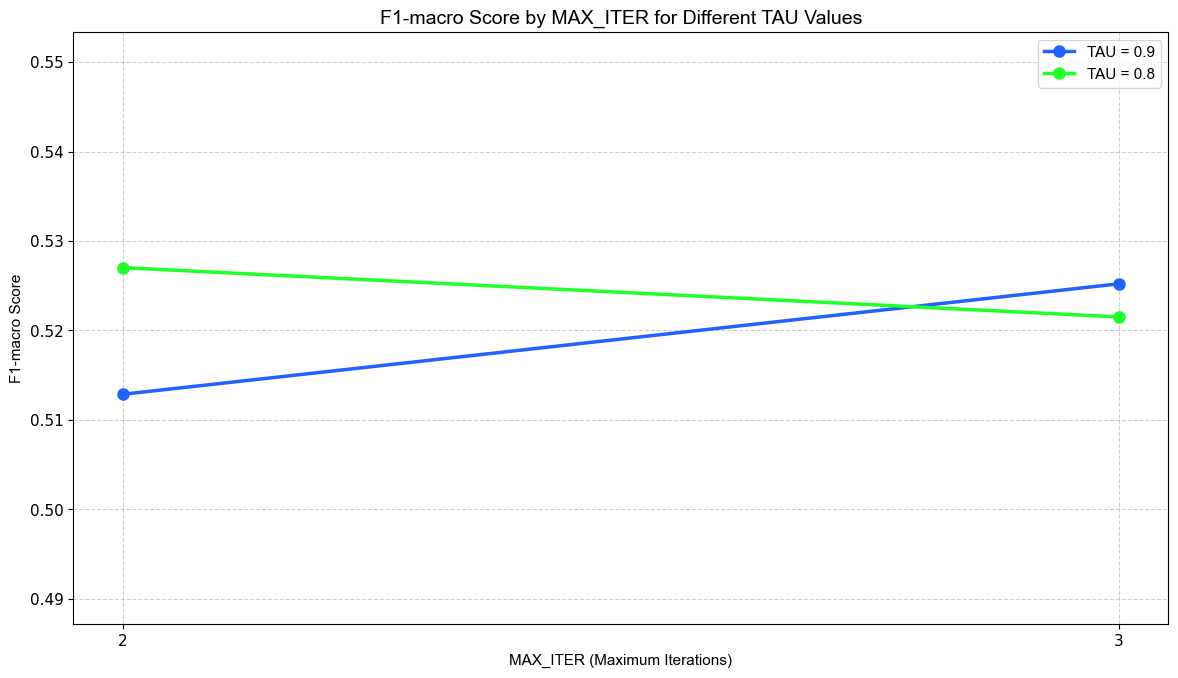

In [8]:
# -------- Biểu đồ 2: So sánh F1-macro (Biểu đồ đường) --------
if 'df_results' in locals() and not df_results.empty:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Chuẩn bị dữ liệu
    taus = sorted(df_results["tau"].unique(), reverse=True)
    max_iters = sorted(df_results["max_iter"].unique())
    
    # Định nghĩa bảng màu cho các giá trị TAU
    # Sử dụng các tông màu được phép
    tau_colors = {
        0.9: '#1F62FF',  # Xanh nước biển đậm
        0.8: '#1FFF2A',  # Xanh lá cây
        0.7: '#FF9A1F',  # Cam
        0.6: '#FF351F',  # Đỏ
    }
    
    # Vẽ đường cho mỗi giá trị TAU
    for tau_val in taus:
        # Lọc dữ liệu theo TAU và sắp xếp theo MAX_ITER
        tau_data = df_results[df_results["tau"] == tau_val].sort_values("max_iter")
        
        # Vẽ đường với marker
        ax.plot(tau_data["max_iter"], tau_data["f1_macro"], 
                marker='o', 
                linewidth=2.5, 
                markersize=8,
                color=tau_colors.get(tau_val, '#1F62FF'),
                label=f'TAU = {tau_val}')
    
    # Thêm nhãn và tiêu đề
    ax.set_xlabel('MAX_ITER (Maximum Iterations)', **FONT_CONFIG)
    ax.set_ylabel('F1-macro Score', **FONT_CONFIG)
    
    title_font_config = FONT_CONFIG.copy()
    title_font_config['fontsize'] = 14
    ax.set_title('F1-macro Score by MAX_ITER for Different TAU Values', **title_font_config)
    
    # Cấu hình trục và lưới
    ax.set_xticks(max_iters)
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(prop={'family': 'Arial', 'size': 11}, loc='best')
    
    # Đặt giới hạn trục y
    y_min = df_results['f1_macro'].min() * 0.95
    y_max = df_results['f1_macro'].max() * 1.05
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout(pad=1.5)
    
    # Lưu biểu đồ
    save_path = IMAGES_DIR / "10_03_f1_macro_line_chart.png"
    plt.savefig(save_path, dpi=300)
    print(f"Biểu đồ đường đã được lưu tại: {save_path}")
    
    plt.show()


Biểu đồ nhiệt đã được lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\10_02_f1_macro_heatmap.png


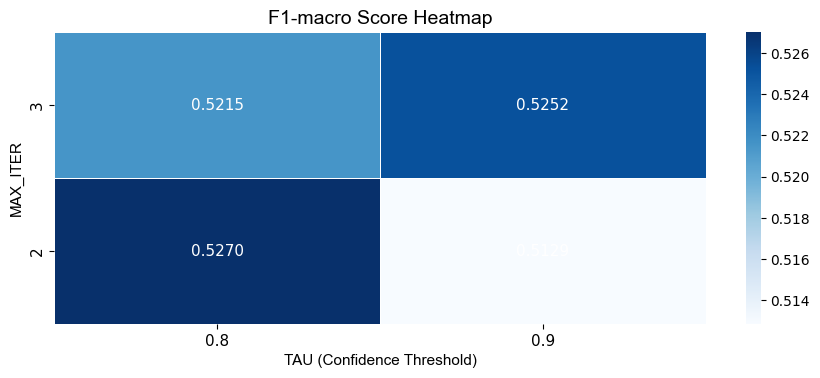

In [9]:
# -------- Biểu đồ 2: Heatmap F1-macro --------
if 'df_results' in locals() and not df_results.empty:
    try:
        # Pivot a DataFrame for heatmap
        pivot_df = df_results.pivot(index="max_iter", columns="tau", values="f1_macro")
        pivot_df = pivot_df.sort_index(ascending=False) # Sắp xếp lại cho trực quan

        fig, ax = plt.subplots(figsize=(9, 4))
        
        # Create heatmap
        sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="Blues", linewidths=.5, ax=ax,
                    annot_kws={"color": "white", "size": 11})

        # Set title and labels
        # Sửa lỗi TypeError: Tạo một dict riêng cho title
        title_font_config = FONT_CONFIG.copy()
        title_font_config['fontsize'] = 14
        ax.set_title('F1-macro Score Heatmap', **title_font_config)

        ax.set_xlabel('TAU (Confidence Threshold)', **FONT_CONFIG)
        ax.set_ylabel('MAX_ITER', **FONT_CONFIG)
        ax.tick_params(axis='both', labelsize=11)
        
        plt.tight_layout(pad=1.5)

        # Save figure
        save_path = IMAGES_DIR / "10_02_f1_macro_heatmap.png"
        plt.savefig(save_path, dpi=300)
        print(f"Biểu đồ nhiệt đã được lưu tại: {save_path}")

        plt.show()
    except Exception as e:
        print(f"Lỗi khi tạo heatmap: {e}")
        print("Vui lòng đảm bảo có đủ dữ liệu từ các thử nghiệm.")
